In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms,io
from torch import utils

### datasets.ImageFolder returns Dataset object with contains tuples => (image, class).

In [21]:
transform = transforms.Compose([transforms.Resize((255,255)),transforms.ToTensor()])
dataset = datasets.ImageFolder('./archive/caltech101_classification/',transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset saves the tuple for all images in the form (imageMatrix,imageLabel)

In [22]:
trainData,testData = utils.data.random_split(dataset,[1330,331])

~~ImageFolder will apply transformation lazily i.e. when ever an image is called then only it will apply transformation.<br>
Ex.print(dataset[15][0].shape) - When this statement is called, it will execute transforms on this one image only<br>
When we random_split 'dataset' into traning, testing, validation, (random_split will not execute the transforms on the images in datset, instead it will just split the list of images into three sets i.e. training,testing,validaiton) and when we call these images it will load original images from disk without transformation.<br>
So to we have to individually apply transforms on each sets (traning,testing,validation)~~ <br><br>
Transformation of 'dataset' will also be applied to train, test, validation split

In [23]:
trainDataLoader = torch.utils.data.DataLoader(trainData, batch_size=32, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testData, batch_size=32, shuffle=True)

**********************************************************************************************************

In [26]:
# Implementation of CNN/ConvNet Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        # Conv -> (?, 28, 28, 32)
        # Pool -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
#             torch.nn.Dropout(p=1 - keep_prob)
        )
        # L2 ImgIn shape=(?, 14, 14, 32)
        # Conv      ->(?, 14, 14, 64)
        # Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
#             torch.nn.Dropout(p=1 - keep_prob)
        )
        # L3 ImgIn shape=(?, 7, 7, 64)
        # Conv ->(?, 7, 7, 128)
        # Pool ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
#             torch.nn.Dropout(p=1 - keep_prob)
        )

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(32 * 32 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU()
#             torch.nn.Dropout(p=1 - keep_prob)
        )
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 3, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


#instantiate CNN model
model = CNN()
model


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=131072, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=131072, out_features=625, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=625, out_features=3, bias=True)
)

In [12]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [13]:
from torch.autograd import Variable
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 5
total_batch = len(trainDataLoader) // 32 #batch_size

# print('Size of the training dataset is {}'.format(trainData.data.size()))
# print('Size of the testing dataset'.format(testDataLoader.data.size()))
# # print('Batch size is : {}'.format(batch_size))
# # print('Total number of batches is : {0:2.0f}'.format(total_batch))
# print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(trainDataLoader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))


print('Learning Finished!')


Training the Deep Learning network ...
Epoch= 1,	 batch = 0,	 cost = 1.1156,	 accuracy = 0.03125
[Epoch:    1], averaged cost = inf
Epoch= 2,	 batch = 0,	 cost = 0.8623,	 accuracy = 0.8125
[Epoch:    2], averaged cost = inf
Epoch= 3,	 batch = 0,	 cost = 0.5508,	 accuracy = 0.8125
[Epoch:    3], averaged cost = inf
Epoch= 4,	 batch = 0,	 cost = 0.0064,	 accuracy = 1.0
[Epoch:    4], averaged cost = inf
Epoch= 5,	 batch = 0,	 cost = 0.0012,	 accuracy = 1.0
[Epoch:    5], averaged cost = inf
Learning Finished!


In [14]:
type(testData[0][0])

torch.Tensor

In [15]:
# # Test model and check accuracy
# model.eval()    # set the model to evaluation mode (dropout=False)

# X_test = Variable(testData[0][0].view(len(testData[0][0]), 255, 255).float())
# # Y_test = Variable(testData[0][1])
# print(X_test)

# prediction = model(X_test)
# print(prediction)

# Compute accuracy
# correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
# accuracy = correct_prediction.float().mean().item()
# print('\nAccuracy: {:2.2f} %'.format(accuracy*100))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testDataLoader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


Motorbikes


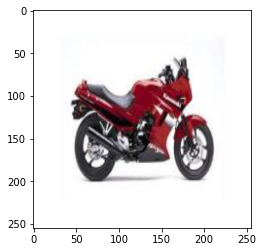

In [16]:
plt.imshow(testData[0][0].permute(1,2,0))
print(testData.dataset.classes[testData[0][1]])

In [17]:
for data in testDataLoader:
    im,label = data
    print("lable=",label)
    op=model(im)
    print(op.data)
    _, predicted = torch.max(op.data, 1)
    print(predicted)
    break

lable= tensor([2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0])
tensor([[ -2.4549,  -2.4703,   3.3772],
        [ -3.8393,   8.2727,  -2.9189],
        [  1.4143,  12.0575,  -8.7138],
        [ -0.4720,   6.8514,  -4.2258],
        [ -1.9086,   8.6503,  -4.4176],
        [ -2.5214,   7.5139,  -3.4539],
        [ 10.8257,   4.9713, -10.0350],
        [  2.8582,  13.0244,  -9.9364],
        [  1.6674,  10.7534,  -7.9706],
        [ -0.6157,  13.0340,  -8.0971],
        [  0.7389,  11.0207,  -7.4198],
        [ -0.7037,  12.1331,  -7.3413],
        [  7.9501,   7.4324,  -9.6441],
        [ -4.5239,   7.7136,  -1.9903],
        [ -3.3492,   4.7524,  -0.9237],
        [ 10.0068,   7.8584, -11.4534],
        [  9.6223,   3.6256,  -8.5215],
        [  1.3910,  11.3280,  -8.0404],
        [ -1.2152,   8.3823,  -4.7129],
        [ 15.2740,  -1.2458,  -8.8713],
        [  0.9913,  11.9841,  -8.4128],
        [ 15.1961,  -3.9188,  -7.0409],


In [54]:
for i in testDataLoader:
    print(type(i))
    break

<class 'list'>


In [53]:
for i in predicted:
    print(testData.dataset.classes[i])

schooner
airplanes
airplanes
airplanes
airplanes
airplanes
Motorbikes
airplanes
airplanes
airplanes
airplanes
airplanes
Motorbikes
airplanes
airplanes
Motorbikes
Motorbikes
airplanes
airplanes
Motorbikes
airplanes
Motorbikes
airplanes
airplanes
Motorbikes
Motorbikes
Motorbikes
Motorbikes
airplanes
Motorbikes
airplanes
Motorbikes


## Checking if train 

In [19]:
from collections import Counter
Counter([i[1] for i in trainData])

Counter({0: 431, 1: 462, 2: 37})